## Complex Navier Stokes equations
In the following code I modify the basic configuration of the vein model to use a function as upper limit and lower limit

In [18]:
# Librerias necesarias
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

100%|██████████| 500/500 [00:02<00:00, 238.26it/s]


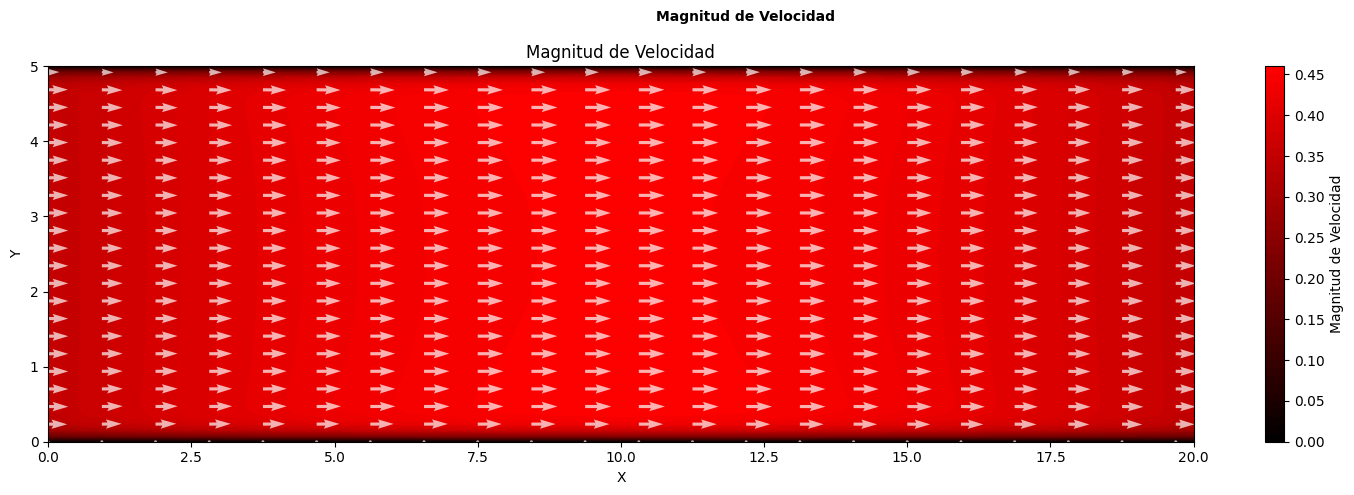

Simulación completada.


In [46]:
# Constantes
N_POINTS = 65  # Numero de puntos en cada dirección
# ==========================================
#DOMAIN_SIZE = 15.0 Tamaño del dominio 
DOMAIN_SIZE_X = 20.0  # Tamaño del dominio en X
DOMAIN_SIZE_Y = 5.0  # Tamaño del dominio en Y
# ==========================================
N_ITERATIONS = 500 # Numero de iteraciones
TIME_STEP_LENGTH = 0.0005
KINEMATIC_VISCOSITY = 5 # Viscosidad cinemática (0.1 para flujo laminar, 0.5 para más turbulento)
DENSITY = 1.0 # Densidad del fluido (1.0 para fluido genérico)
# HORINZONTAL_VELOCITY_TOP = 1.0
PRESSURE_GRADIENT = -0.1  # Gradiente de presión que impulsa el flujo
N_PRESSURE_POISSON_ITERATION = 100  # Iteraciones para resolver la ecuación de Poisson

def main_1():
    element_length = DOMAIN_SIZE_X / (N_POINTS - 1)
    
    # Crear la malla
    x = np.linspace(0.0, DOMAIN_SIZE_X, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE_Y, N_POINTS)
    X, Y = np.meshgrid(x, y)
    
    # Inicializar campos
    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)

    # Aplicar gradiente de presión lineal en X
    for i in range(N_POINTS):
        p_prev[:, i] = PRESSURE_GRADIENT * x[i]

    # Funciones de diferencias finitas 
    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * element_length)
        return diff

    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * element_length)
        return diff

    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + 
            f[1:-1, 2:] + f[2:, 1:-1]) / (element_length * 2)
        return diff

    # Simulación principal
    for i in tqdm(range(N_ITERATIONS)):


        # Calcular derivadas
        d_u_prev_d_x = central_difference_x(u_prev)
        d_u_prev_d_y = central_difference_y(u_prev)
        d_v_prev_d_x = central_difference_x(v_prev)
        d_v_prev_d_y = central_difference_y(v_prev)
        d_p_prev_d_x = central_difference_x(p_prev)
        
        laplace_u_prev = laplace(u_prev)
        laplace_v_prev = laplace(v_prev)

        # Paso de velocidad CON GRADIENTE DE PRESIÓN
        u_tent = u_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_u_prev_d_x + v_prev * d_u_prev_d_y) 
            - (1/DENSITY) * d_p_prev_d_x  # Término de presión
            + KINEMATIC_VISCOSITY * laplace_u_prev
        )
        
        v_tent = v_prev + TIME_STEP_LENGTH * (
            -(u_prev * d_v_prev_d_x + v_prev * d_v_prev_d_y) 
            + KINEMATIC_VISCOSITY * laplace_v_prev
        )

        # CONDICIONES DE FRONTERA PARA EL FLUJO
        # Paredes superior e inferior: NO MOVIMIENTO
        u_tent[0, :] = 0.0                    # Inferior
        u_tent[-1, :] = 0.0                   # Superior
        
        # Laterales: periódicas
        u_tent[:, 0] = u_tent[:, -2]          
        u_tent[:, -1] = u_tent[:, 1]          
        
        v_tent[0, :] = 0.0                    # Inferior
        v_tent[-1, :] = 0.0                   # Superior
        v_tent[:, 0] = v_tent[:, -2]          # Izquierda
        v_tent[:, -1] = v_tent[:, 1]          # Derecha

        # Calcular RHS para ecuación de Poisson
        d_u_tent_d_x = central_difference_x(u_tent)
        d_v_tent_d_y = central_difference_y(v_tent)
        
        rhs = DENSITY / TIME_STEP_LENGTH * (d_u_tent_d_x + d_v_tent_d_y)

        # Resolver ecuación de Poisson para presión
        for _ in range(N_PRESSURE_POISSON_ITERATION):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (
                p_prev[1:-1, 0:-2] + p_prev[0:-2, 1:-1] + 
                p_prev[1:-1, 2:] + p_prev[2:, 1:-1] - 
                element_length ** 2 * rhs[1:-1, 1:-1]
            )
            
            # Condiciones de frontera para presión
            p_next[:, -1] = p_next[:, -2]    # Derecha
            p_next[0, :] = p_next[1, :]      # Inferior
            p_next[:, 0] = p_next[:, 1]      # Izquierda
            p_next[-1, :] = p_next[-2, :]    # Superior
            
            # Mantener el gradiente de presión
            p_next = p_next + PRESSURE_GRADIENT * X
            
            p_prev = p_next

        # Corrección de velocidad
        d_p_next_d_x = central_difference_x(p_next)
        d_p_next_d_y = central_difference_y(p_next)
        
        u_next = u_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_x
        v_next = v_tent - TIME_STEP_LENGTH / DENSITY * d_p_next_d_y

        # Aplicar condiciones de frontera finales
        u_next[0, :] = 0.0    # Inferior
        u_next[-1, :] = 0.0   # Superior
        u_next[:, 0] = u_next[:, -2]
        u_next[:, -1] = u_next[:, 1]
        
        v_next[0, :] = 0.0    # Inferior
        v_next[-1, :] = 0.0   # Superior
        v_next[:, 0] = v_next[:, -2]
        v_next[:, -1] = v_next[:, 1]

        # Actualizar para siguiente iteración
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
            #************Graficar****************
    fig, ax = plt.subplots(figsize=(15, 5)) # Figura alargada
    fig.suptitle('Magnitud de Velocidad', fontsize=10, fontweight='bold')

    velocity_magnitude = np.sqrt(u_next**2 + v_next**2)

        # Colormap negro→rojo
    black_red = LinearSegmentedColormap.from_list("black_red", ["black", "red"])

        # 2. Magnitud de velocidad
    contour = ax.contourf(X, Y, velocity_magnitude, levels=50, cmap=black_red, alpha=1.0)
    ax.quiver(X[::3, ::3], Y[::3, ::3], u_next[::3, ::3], v_next[::3, ::3],
                scale=20, color='white', alpha=0.7) # Flechas de velocidad
    ax.set_title('Magnitud de Velocidad')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.colorbar(contour, ax=ax, label='Magnitud de Velocidad')

    plt.tight_layout()
    plt.show()
    print("Simulación completada.")

if __name__ == "__main__":
    main_1()

Inicializando simulación con geometría funcional...
Precalculando matriz de Poisson...
Iniciando simulación...
Paso 0/500 (t=0.000s)
Paso 100/500 (t=0.010s)
Paso 200/500 (t=0.020s)
Paso 300/500 (t=0.030s)
Paso 400/500 (t=0.040s)
Simulación completada. Creando visualizaciones...


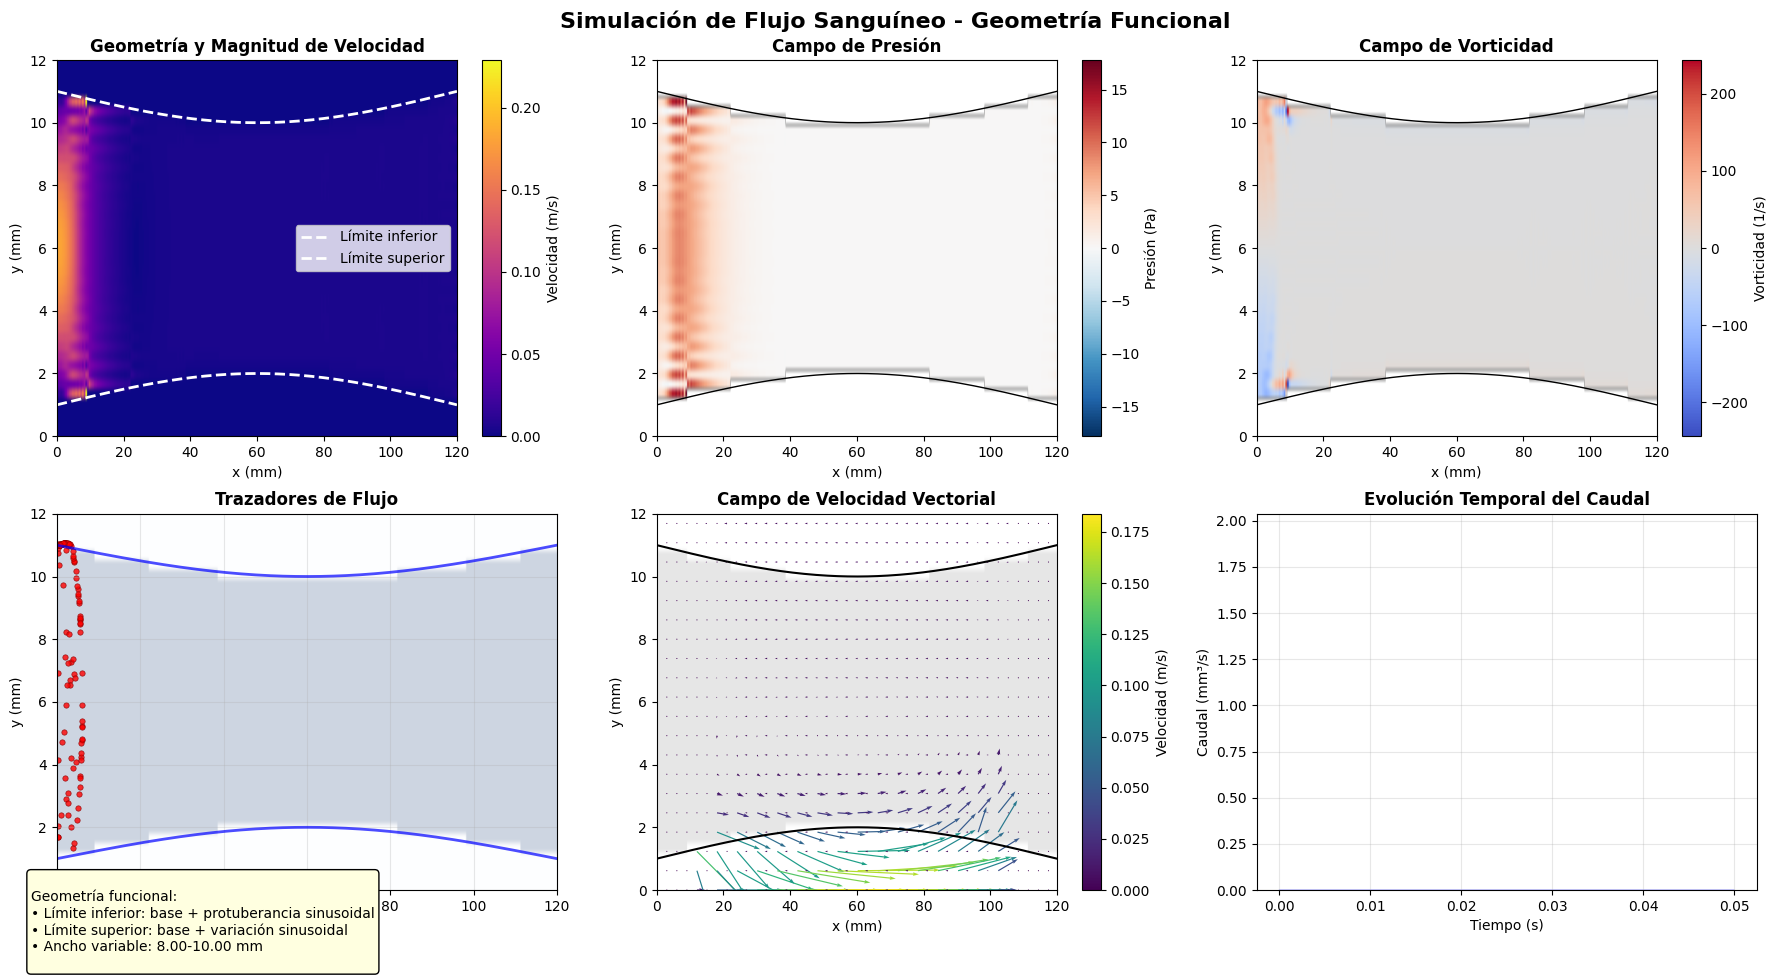

Visualización completada exitosamente!


In [ ]:
# Otra versión

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import sparse
from scipy.sparse.linalg import spsolve
import math
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------------------
# Parámetros físicos y numéricos
# ---------------------------
rho = 1060.0          # kg/m^3 (densidad de sangre)
mu = 0.004            # Pa·s (viscosidad dinámica de sangre) 
nu = mu / rho         # m^2/s (viscosidad cinemática)

Lx = 0.12             # m (longitud de la vena)
Ly = 0.012            # m (altura de referencia)
Nx = 240              # puntos en x
Ny = 40               # puntos en y
dx = Lx / (Nx - 1)    # paso espacial en x
dy = Ly / (Ny - 1)    # paso espacial en y

# Tiempo
dt = 1e-4             # paso temporal
n_steps = 500        # número de pasos de tiempo

# Parámetros de control
MAX_VEL = 2.0         # m/s (velocidad máxima)
RESEED_MARGIN = 1e-6  # margen para resembrar partículas

# Malla
x_grid = np.linspace(0, Lx, Nx)
y_grid = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x_grid, y_grid, indexing='ij')

# ========== GEOMETRÍA MODIFICABLE ==========
# Definir funciones para los límites superior e inferior
def limite_inferior(x):
    return 0.001 + 0.001 * np.sin(np.pi * x / Lx)

def limite_superior(x):
    return 0.011 - 0.001 * np.sin(np.pi * x / Lx)

# Crear máscara basada en las funciones de límite
lim_inf = limite_inferior(X)
lim_sup = limite_superior(X)
mask = (Y >= lim_inf) & (Y <= lim_sup)

# ========== RESTAURAR CENTRO Y RADIO PARA EL PERFIL DE ENTRADA ==========
# Para el perfil de entrada parabólico, necesitamos un centro y radio efectivos
center_y_func = (lim_sup[0, :] + lim_inf[0, :]) / 2  # Centro en x=0
radius_func = (lim_sup[0, :] - lim_inf[0, :]) / 2     # Radio en x=0

# Campos iniciales
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Partículas trazadoras - CORREGIDO para geometría funcional
n_particles = 120
# Encontrar puntos válidos en la entrada (x=0)
valid_inlet_indices = np.where(mask[0, :])[0]
if len(valid_inlet_indices) == 0:
    raise RuntimeError("No hay puntos de máscara en la entrada (x=0). Revisa las funciones de límite.")

# Inicializar partículas dentro de la geometría en x=0
particles_x = np.random.uniform(1e-6, 1e-6, n_particles)
# Las partículas deben estar entre los límites inferior y superior en x=0
y_min_inlet = np.min(lim_inf[0, valid_inlet_indices])
y_max_inlet = np.max(lim_sup[0, valid_inlet_indices])
particles_y = np.random.uniform(y_min_inlet, y_max_inlet, n_particles)
particles = np.column_stack((particles_x, particles_y))

# Perfil de entrada pulsátil adaptado a geometría variable
U_max_mean = 0.15
pulse_amp = 0.6
heart_rate = 75.0
omega = 2.0 * math.pi * heart_rate / 60.0

def inlet_profile(y_local, t):
    """Perfil parabólico pulsátil adaptado a geometría variable"""
    profile = np.zeros_like(y_local)
    amp = 1.0 + pulse_amp * math.sin(omega * t)
    
    # Para cada posición y, verificar si está dentro de los límites en x=0
    for i, y_val in enumerate(y_local):
        if lim_inf[0, i] <= y_val <= lim_sup[0, i]:
            # Distancia normalizada desde el centro local
            y_center_local = (lim_sup[0, i] + lim_inf[0, i]) / 2
            local_radius = (lim_sup[0, i] - lim_inf[0, i]) / 2
            r = np.abs(y_val - y_center_local)
            if local_radius > 0:
                profile[i] = U_max_mean * amp * (1.0 - (r / local_radius) ** 2)
    
    return profile

def apply_boundary_conditions(u_field, v_field, p_field, t):
    """Aplicar condiciones de contorno para geometría funcional"""
    # Resetear campos fuera de la máscara
    u_field[~mask] = 0.0
    v_field[~mask] = 0.0
    
    # Condición de entrada (x=0)
    ycoords = Y[0, :]
    u_in = inlet_profile(ycoords, t)
    inlet_mask = mask[0, :]
    u_field[0, inlet_mask] = u_in[inlet_mask]
    v_field[0, :] = 0.0  # Sin flujo vertical en entrada
    
    # Condición de salida (x=Lx) - presión cero
    outlet_mask = mask[-1, :]
    p_field[-1, outlet_mask] = 0.0
    
    # Condiciones de pared (no deslizamiento) - ya aplicado por la máscara
    
    return u_field, v_field, p_field

# [MANTENER TODAS LAS FUNCIONES DE CÁLCULO (ddx, ddy, laplacian, etc.) DEL CÓDIGO ORIGINAL]

# Derivadas discretas (las mismas del código original)
def ddx(f):
    df = np.zeros_like(f)
    df[1:-1, :] = (f[2:, :] - f[:-2, :]) / (2.0 * dx)
    df[0, :] = (f[1, :] - f[0, :]) / dx
    df[-1, :] = (f[-1, :] - f[-2, :]) / dx
    return df

def ddy(f):
    df = np.zeros_like(f)
    df[:, 1:-1] = (f[:, 2:] - f[:, :-2]) / (2.0 * dy)
    df[:, 0] = (f[:, 1] - f[:, 0]) / dy
    df[:, -1] = (f[:, -1] - f[:, -2]) / dy
    return df

def laplacian(f):
    lap = np.zeros_like(f)
    lap[1:-1, 1:-1] = (
        (f[2:, 1:-1] - 2.0 * f[1:-1, 1:-1] + f[:-2, 1:-1]) / dx**2 +
        (f[1:-1, 2:] - 2.0 * f[1:-1, 1:-1] + f[1:-1, :-2]) / dy**2
    )
    return lap

# [MANTENER Poisson solver, CFL helper, interpolation functions DEL CÓDIGO ORIGINAL]

# Poisson solver usando matrices esparcidas
def build_poisson_matrix(mask_local):
    N = np.sum(mask_local)
    idx_map = np.full(mask_local.shape, -1, dtype=int)
    idx_map[mask_local] = np.arange(N)
    
    dx2 = dx * dx
    dy2 = dy * dy
    diag_coef = -2/dx2 - 2/dy2
    
    row_indices = []
    col_indices = []
    data = []
    
    for i in range(Nx):
        for j in range(Ny):
            if not mask_local[i, j]:
                continue
                
            idx = idx_map[i, j]
            row_indices.append(idx)
            col_indices.append(idx)
            data.append(diag_coef)
            
            if j + 1 < Ny and mask_local[i, j + 1]:
                nidx = idx_map[i, j + 1]
                row_indices.append(idx)
                col_indices.append(nidx)
                data.append(1/dy2)
            
            if j - 1 >= 0 and mask_local[i, j - 1]:
                nidx = idx_map[i, j - 1]
                row_indices.append(idx)
                col_indices.append(nidx)
                data.append(1/dy2)
            
            if i + 1 < Nx and mask_local[i + 1, j]:
                nidx = idx_map[i + 1, j]
                row_indices.append(idx)
                col_indices.append(nidx)
                data.append(1/dx2)
            
            if i - 1 >= 0 and mask_local[i - 1, j]:
                nidx = idx_map[i - 1, j]
                row_indices.append(idx)
                col_indices.append(nidx)
                data.append(1/dx2)
    
    A = sparse.csr_matrix((data, (row_indices, col_indices)), shape=(N, N))
    return A, idx_map

def solve_pressure_poisson_fast(p_field, rhs, mask_local, A_poisson, idx_map):
    rhs_flat = rhs[mask_local]
    p_flat = spsolve(A_poisson, rhs_flat)
    p_result = np.zeros_like(p_field)
    p_result[mask_local] = p_flat
    return p_result

def cfl_safe_dt(u_field, v_field):
    umax = max(1e-8, np.nanmax(np.abs(u_field)))
    vmax = max(1e-8, np.nanmax(np.abs(v_field)))
    dt_conv = min(dx / umax, dy / vmax)
    dt_visc = 0.25 * min(dx*dx, dy*dy) / max(1e-12, nu)
    return min(dt_conv * 0.4, dt_visc, dt)

def interpolate_velocity(x, y, u_field, v_field):
    i = np.clip(np.floor(x / dx).astype(int), 0, Nx-2)
    j = np.clip(np.floor(y / dy).astype(int), 0, Ny-2)
    
    sx = np.clip((x - x_grid[i]) / dx, 0.0, 1.0)
    sy = np.clip((y - y_grid[j]) / dy, 0.0, 1.0)
    
    u00 = u_field[i, j];     u10 = u_field[i+1, j]
    u01 = u_field[i, j+1];   u11 = u_field[i+1, j+1]
    
    v00 = v_field[i, j];     v10 = v_field[i+1, j]
    v01 = v_field[i, j+1];   v11 = v_field[i+1, j+1]
    
    uk = (1-sx)*(1-sy)*u00 + sx*(1-sy)*u10 + (1-sx)*sy*u01 + sx*sy*u11
    vk = (1-sx)*(1-sy)*v00 + sx*(1-sy)*v10 + (1-sx)*sy*v01 + sx*sy*v11
    
    uk = np.nan_to_num(uk, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    vk = np.nan_to_num(vk, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    uk = np.clip(uk, -MAX_VEL, MAX_VEL)
    vk = np.clip(vk, -MAX_VEL, MAX_VEL)
    
    return uk, vk

def update_particles_vectorized(particles, u_field, v_field, dt_local, mask):
    """Actualiza partículas para geometría funcional"""
    x, y = particles[:, 0], particles[:, 1]
    
    uk1, vk1 = interpolate_velocity(x, y, u_field, v_field)
    x_mid = x + 0.5 * dt_local * uk1
    y_mid = y + 0.5 * dt_local * vk1
    uk2, vk2 = interpolate_velocity(x_mid, y_mid, u_field, v_field)
    x_new = x + dt_local * uk2
    y_new = y + dt_local * vk2
    
    # Verificar si las partículas están dentro de los límites funcionales
    i_new = np.clip(np.floor(x_new / dx).astype(int), 0, Nx-1)
    j_new = np.clip(np.floor(y_new / dy).astype(int), 0, Ny-1)
    
    invalid_mask = (
        ~np.isfinite(x_new) | ~np.isfinite(y_new) |
        (x_new < 0) | (x_new >= Lx) | 
        (y_new < 0) | (y_new >= Ly) |
        ~mask[i_new, j_new]  # Usar la máscara geométrica
    )
    
    # Resembrar partículas inválidas en la entrada
    n_invalid = np.sum(invalid_mask)
    if n_invalid > 0:
        # Resembrar en x=0 entre los límites inferior y superior
        y_min = np.min(lim_inf[0, valid_inlet_indices])
        y_max = np.max(lim_sup[0, valid_inlet_indices])
        y0_reseed = np.random.uniform(y_min, y_max, n_invalid)
        x_new[invalid_mask] = RESEED_MARGIN
        y_new[invalid_mask] = y0_reseed
    
    return np.column_stack((x_new, y_new))

# ========== SIMULACIÓN PRINCIPAL ==========
print("Inicializando simulación con geometría funcional...")

# Aplicar condiciones iniciales
u, v, p = apply_boundary_conditions(u, v, p, t=0.0)

# Preparar almacenamiento
snapshots = []
times = []
flow_rates = []

t = 0.0
snapshot_interval = max(1, n_steps // 40)

# Precalcular matriz de Poisson
print("Precalculando matriz de Poisson...")
A_poisson, idx_map_poisson = build_poisson_matrix(mask)

print("Iniciando simulación...")
for step in range(n_steps):
    if step % 100 == 0:
        print(f"Paso {step}/{n_steps} (t={t:.3f}s)")
    
    dt_local = min(dt, cfl_safe_dt(u, v))
    if dt_local < 1e-8:
        dt_local = 1e-8

    # Fuerza por gradiente de presión pulsátil
    pressure_gradient_amp = 100.0
    fx_val = - (pressure_gradient_amp * (1.0 + 0.7 * math.sin(omega * t))) / rho
    fx = np.zeros_like(u)
    fx[mask] = fx_val

    # Términos convectivos y viscosos
    du_dx = ddx(u); du_dy = ddy(u)
    dv_dx = ddx(v); dv_dy = ddy(v)
    
    conv_u = u * du_dx + v * du_dy
    conv_v = u * dv_dx + v * dv_dy
    
    lap_u = laplacian(u)
    lap_v = laplacian(v)

    # Paso predictor
    u_tent = u + dt_local * (-conv_u + nu * lap_u + fx)
    v_tent = v + dt_local * (-conv_v + nu * lap_v)

    # Limpiar campos
    u_tent[~mask] = 0.0; v_tent[~mask] = 0.0
    u_tent = np.nan_to_num(u_tent, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    v_tent = np.nan_to_num(v_tent, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    u_tent = np.clip(u_tent, -MAX_VEL, MAX_VEL)
    v_tent = np.clip(v_tent, -MAX_VEL, MAX_VEL)

    # Paso corrector de presión
    div_tent = ddx(u_tent) + ddy(v_tent)
    rhs = (rho / dt_local) * div_tent
    
    p_new = solve_pressure_poisson_fast(p, rhs, mask, A_poisson, idx_map_poisson)

    # Corregir velocidad
    dpdx = ddx(p_new)
    dpdy = ddy(p_new)
    
    u_new = u_tent - (dt_local / rho) * dpdx
    v_new = v_tent - (dt_local / rho) * dpdy

    # Limpiar y aplicar condiciones de contorno
    u_new = np.nan_to_num(u_new, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    v_new = np.nan_to_num(v_new, nan=0.0, posinf=MAX_VEL, neginf=-MAX_VEL)
    u_new = np.clip(u_new, -MAX_VEL, MAX_VEL)
    v_new = np.clip(v_new, -MAX_VEL, MAX_VEL)
    
    u_new, v_new, p_new = apply_boundary_conditions(u_new, v_new, p_new, t + dt_local)

    u, v, p = u_new, v_new, p_new
    t += dt_local

    # Actualizar partículas
    particles = update_particles_vectorized(particles, u, v, dt_local, mask)

    # Calcular caudal en sección media
    j_mid = Nx // 2
    u_section = u[j_mid, :] * mask[j_mid, :]
    flow_rate = np.trapz(u_section, dx=dy)
    flow_rates.append(flow_rate)

    if (step % snapshot_interval) == 0:
        snapshots.append((u.copy(), v.copy(), p.copy(), particles.copy()))
        times.append(t)

# ========== VISUALIZACIÓN MEJORADA PARA GEOMETRÍA FUNCIONAL ==========
print("Simulación completada. Creando visualizaciones...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Simulación de Flujo Sanguíneo - Geometría Funcional', fontsize=16, fontweight='bold')

u_last, v_last, p_last, particles_last = snapshots[-1]
speed = np.sqrt(u_last**2 + v_last**2)

# 1. Geometría y magnitud de velocidad
im0 = axes[0,0].imshow(speed.T, extent=[0, Lx*1000, 0, Ly*1000], origin='lower', 
                      cmap='plasma', aspect='auto', vmin=0, vmax=np.max(speed))
# Dibujar los límites funcionales
axes[0,0].plot(x_grid*1000, lim_inf[:, 0]*1000, 'w--', linewidth=2, label='Límite inferior')
axes[0,0].plot(x_grid*1000, lim_sup[:, 0]*1000, 'w--', linewidth=2, label='Límite superior')
axes[0,0].set_title("Geometría y Magnitud de Velocidad", fontweight='bold')
axes[0,0].set_xlabel("x (mm)"); axes[0,0].set_ylabel("y (mm)")
axes[0,0].legend()
cbar0 = plt.colorbar(im0, ax=axes[0,0])
cbar0.set_label('Velocidad (m/s)')

# 2. Campo de presión
p_plot = p_last.copy()
p_plot[~mask] = np.nan
vmax_p = max(np.abs(np.nanmin(p_plot)), np.abs(np.nanmax(p_plot)))
im1 = axes[0,1].imshow(p_plot.T, extent=[0, Lx*1000, 0, Ly*1000], origin='lower',
                      cmap='RdBu_r', aspect='auto', vmin=-vmax_p, vmax=vmax_p)
axes[0,1].plot(x_grid*1000, lim_inf[:, 0]*1000, 'k-', linewidth=1)
axes[0,1].plot(x_grid*1000, lim_sup[:, 0]*1000, 'k-', linewidth=1)
axes[0,1].set_title("Campo de Presión", fontweight='bold')
axes[0,1].set_xlabel("x (mm)"); axes[0,1].set_ylabel("y (mm)")
cbar1 = plt.colorbar(im1, ax=axes[0,1])
cbar1.set_label('Presión (Pa)')

# 3. Vorticidad
vorticity = ddx(v_last) - ddy(u_last)
vorticity[~mask] = np.nan
vmax_vort = max(np.abs(np.nanmin(vorticity)), np.abs(np.nanmax(vorticity)))
im2 = axes[0,2].imshow(vorticity.T, extent=[0, Lx*1000, 0, Ly*1000], origin='lower',
                      cmap='coolwarm', aspect='auto', vmin=-vmax_vort, vmax=vmax_vort)
axes[0,2].plot(x_grid*1000, lim_inf[:, 0]*1000, 'k-', linewidth=1)
axes[0,2].plot(x_grid*1000, lim_sup[:, 0]*1000, 'k-', linewidth=1)
axes[0,2].set_title("Campo de Vorticidad", fontweight='bold')
axes[0,2].set_xlabel("x (mm)"); axes[0,2].set_ylabel("y (mm)")
cbar2 = plt.colorbar(im2, ax=axes[0,2])
cbar2.set_label('Vorticidad (1/s)')

# 4. Partículas trazadoras
axes[1,0].imshow(mask.T, extent=[0, Lx*1000, 0, Ly*1000], origin='lower', 
                cmap='Blues', alpha=0.2, aspect='auto')
axes[1,0].plot(x_grid*1000, lim_inf[:, 0]*1000, 'b-', linewidth=2, alpha=0.7)
axes[1,0].plot(x_grid*1000, lim_sup[:, 0]*1000, 'b-', linewidth=2, alpha=0.7)
axes[1,0].scatter(particles_last[:, 0]*1000, particles_last[:, 1]*1000, 
                 s=15, c='red', alpha=0.8, edgecolors='darkred', linewidth=0.5)
axes[1,0].set_title("Trazadores de Flujo", fontweight='bold')
axes[1,0].set_xlabel("x (mm)"); axes[1,0].set_ylabel("y (mm)")
axes[1,0].grid(True, alpha=0.3)

# 5. Campo de velocidad vectorial
axes[1,1].imshow(mask.T, extent=[0, Lx*1000, 0, Ly*1000], origin='lower', 
                cmap='Greys', alpha=0.1, aspect='auto')
axes[1,1].plot(x_grid*1000, lim_inf[:, 0]*1000, 'k-', linewidth=1.5)
axes[1,1].plot(x_grid*1000, lim_sup[:, 0]*1000, 'k-', linewidth=1.5)
skip_x, skip_y = 6, 2
speed_vectors = np.sqrt(u_last[::skip_x, ::skip_y]**2 + v_last[::skip_x, ::skip_y]**2)
quiver = axes[1,1].quiver(X[::skip_x, ::skip_y]*1000, Y[::skip_x, ::skip_y]*1000, 
                         u_last[::skip_x, ::skip_y].T, v_last[::skip_x, ::skip_y].T,
                         speed_vectors.T, scale=0.8, width=0.003, cmap='viridis')
axes[1,1].set_title("Campo de Velocidad Vectorial", fontweight='bold')
axes[1,1].set_xlabel("x (mm)"); axes[1,1].set_ylabel("y (mm)")
plt.colorbar(quiver, ax=axes[1,1], label='Velocidad (m/s)')

# 6. Evolución del caudal
t_flow = np.linspace(0, t, len(flow_rates))
axes[1,2].plot(t_flow, np.array(flow_rates)*1e6, 'b-', linewidth=2.5, alpha=0.8)
axes[1,2].fill_between(t_flow, np.array(flow_rates)*1e6, alpha=0.3, color='blue')
axes[1,2].set_title("Evolución Temporal del Caudal", fontweight='bold')
axes[1,2].set_xlabel("Tiempo (s)")
axes[1,2].set_ylabel("Caudal (mm³/s)")
axes[1,2].grid(True, alpha=0.3)
axes[1,2].set_ylim(bottom=0)

# Información de la geometría
geo_text = f"""
Geometría funcional:
• Límite inferior: base + protuberancia sinusoidal
• Límite superior: base + variación sinusoidal
• Ancho variable: {np.min(lim_sup-lim_inf)*1000:.2f}-{np.max(lim_sup-lim_inf)*1000:.2f} mm
"""
fig.text(0.02, 0.02, geo_text, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.1)
plt.show()

print("Visualización completada exitosamente!")